# **Настройки + библиотеки**

In [1]:
!pip install tabgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.7 MB/s eta 0:00:00


In [2]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tabgan.sampler import OriginalGenerator, GANGenerator, ForestDiffusionGenerator
%matplotlib inline
# подключение диска
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/_ctgan/synthesizer.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Mounted at /content/drive


In [3]:
# датасет
dataset_path = '/content/drive/My Drive/Bases/WIND_DBASE/dag_2011_2022_final.csv'

# интесесущая станция
st_name = 'Кочубей'

# интересующие признаки данных
col_list = ['datetime',
            't_air', 't_soil', 'P_atm', 'wind_dir', 'wind_speed']

# границы обучающей выборки
train_borders = ['2011-01-01 00:00:00', '2020-12-31 21:00:00']
# границы проверочной выборки
val_borders = ['2021-01-01 00:00:00', '2021-12-31 21:00:00']
# границы тестовой выборки
test_borders = ['2022-01-01 00:00:00', '2022-12-31 21:00:00']

# **Функции**

**Общие функции**

In [4]:
# подготовка датасета (чтение, выделение признаков, нормировка, класс ветра)
# path - путь к исходнику
# st_name - название станции
# col_list - колонки признаков
# mode = 'category' / 'values'
def process_dataset(path, st_name, col_list, norm_0_1=False):
  # читаем данные
  df = pd.read_csv(path)
  # выделяем станцию
  df = df[df.st_name == st_name]
  # выделяем признаки
  df = df[col_list]
  # перевод градусов угла направления ветра в индекс лепестка розы ветров [0..7]
  def conv_360_to_8(val):
    if val >= 360:
      return 0
    else:
      return val // 45
    return res
  def conv_360_to_16(val):
    if val >= 360:
      return 0
    else:
      return val // 22.5
    return res
  df['wind_dir'] = df['wind_dir'].apply(conv_360_to_16).astype('int32')

  # округление температуры воздуха
  df['t_air'] = df['t_air'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['t_air'] = df['t_air'] - df['t_air'].min()

  # округление температуры почвы
  df['t_soil'] = df['t_soil'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['t_soil'] = df['t_soil'] - df['t_soil'].min()

  # округление атмосферного давления
  df['P_atm'] = df['P_atm'].astype('int32')
  # приведение температуры воздуха к категориям от 0
  df['P_atm'] = df['P_atm'] - df['P_atm'].min()

  # приводим скорости ветра к 3 классам:
  # 0 - от 0 до 3 м/с
  # 1 - от 4 до 7 м/с
  # 2 - от 8 м/с и выше
  def wind_to_class(x):
    if x < 4:
      res = 0
    elif x < 8:
      res = 1
    else:
      res = 2
    return res
  df['wind_class'] = df['wind_speed'].apply(wind_to_class).astype('int32')

  if norm_0_1:
    # нормировка столбцов [0..1]
    for col in col_list[1:]:
      a = df[col].min()
      b = df[col].max()
      df[col] = (df[col] - a)/(b - a)
      df[col] = df[col].astype('float32')

  return df

# нарезка примеров из датафрейма
# df - исходный датафрейм
# days - размер блока данных для X примера (по умолчанию 1 день)
# col_list - колонки c которыми делается выборка
# borders - список из двух значений - границ выборки
def create_samples(df, col_list, borders, days_count=1):
  # выделение данных по границам времени
  rab_df = df[(df.datetime >= borders[0]) & (df.datetime <= borders[1])]
  # размер блока данных
  block_size = days_count * 8
  # начальная позиция текущего смещения в датасете
  pos = 0
  # обнуляем списки примеров...
  samples_x = []
  samples_y = []
  # флаг остановки цикла
  Ex = False
  # нарезка данных в цикле
  while not Ex:
    # если не дошли до конца....
    if pos + block_size < rab_df.shape[0]:
      # формирование вектора X для всех колонок
      x_vec = []
      for col in col_list:
        x_vec.extend(rab_df[col][pos:pos+block_size].to_list())
      # формирование вектора Y
      y_vec = utils.to_categorical(rab_df['wind_class'][pos+block_size:pos+block_size+1].to_list()[0], 3).astype('int')
      # добавление векторов в списки примеров
      samples_x.append(x_vec)
      samples_y.append(y_vec)
    else:
      # прекращение нарезки когда доходим до конца
      Ex = True
    # сдвиг позиции нарезки
    pos += 1 # сдвигаем позицию на 1
  # результат в numpy массивах
  return np.array(samples_x), np.array(samples_y)

# получение весов классов
# df - исходный датафрейм
# borders - список из двух значений - границ выборки
def get_class_weights(df, borders, class_num=3):
  rab_df = df[(df.datetime >= borders[0]) & (df.datetime <= borders[1])]['wind_class']
  class_weights = {}
  for i in range(class_num):
    class_weights[i] = 1.0 / rab_df.value_counts()[i]
  return class_weights

# график обучения
def fit_chart(history):
  # для размера графика...
  def cm_to_inch(value):
    return value/2.54
  plt.figure(figsize=(cm_to_inch(30),cm_to_inch(15)))
  plt.plot([x for x in range(1, len(history.history['accuracy'])+1)],
           history.history['accuracy'],
           label='Точность на обучающем наборе', linewidth=3)
  plt.plot([x for x in range(1, len(history.history['val_accuracy'])+1)],
           history.history['val_accuracy'],
           label='Точность на проверочном наборе', linewidth=3)
  plt.xlabel('Эпоха обучения', fontsize=14)
  plt.ylabel('Точность', fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(True)
  plt.legend(fontsize=14)
  plt.show()

# на основе проверочной или тестовой выборки
# возвращает:
# 1. Точность предсказания
# 2. Список точностей для классов
# 3. Матрицу несоответствий
def get_accuracy_report(model, x, y, class_num=3):
  # предикт
  pred = model.predict(x)
  # массив предсказанных y_pred
  y_pred = []
  for i in range(pred.shape[0]):
    y_pred.append(np.argmax(pred[i]))
  y_pred = np.array(y_pred)
  # numpy массив истинных y_true
  y_true = []
  for i in range(y.shape[0]):
    y_true.append(np.argmax(y[i]))
  y_true = np.array(y_true)
  # матрица несоответсвий
  cm = confusion_matrix(y_true, y_pred)
  res = [None for i in range(class_num)]
  for i in range(class_num):
    res[i] = round(cm[i, i]/(cm[i, :].sum()),3)
  return accuracy_score(y_true, y_pred), res, cm


**Модели**

In [5]:
# только полноcвязный слой
def create_model_dense(x_len, params):

  input = Input((x_len,))

  x = BatchNormalization()(input)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями А
def create_model_conv_a(x_len, params, bs):

  blocks_count = round(x_len / bs)

  input = Input((x_len,))

  xx = [None for i in range(blocks_count)]

  for i in range(blocks_count):

    xx[i] = Reshape((bs, 1))(input[:,i*bs:i*bs+bs])

    #xx[i] = SpatialDropout1D(0.1)(xx[i])
    xx[i] = Conv1D(10, 5, activation=params['activation'])(xx[i])

    xx[i] = Flatten()(xx[i])

  x = concatenate(xx)

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями B
def create_model_conv_b(x_len, params):

  input = Input((x_len,))

  x = Reshape((x_len, 1))(input)

  x1 = Conv1D(10, 3, activation=params['activation'])(x)
  x1 = Flatten()(x1)

  x2 = Conv1D(10, 5, activation=params['activation'])(x)
  x2 = Flatten()(x2)

  x3 = Conv1D(10, 7, activation=params['activation'])(x)
  x3 = Flatten()(x3)

  x = concatenate([x1, x2, x3])

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)

# модель со сверточными слоями А
def create_model_lstm(x_len, params, bs):

  blocks_count = round(x_len / bs)

  input = Input((x_len,))

  xx = [None for i in range(blocks_count)]

  for i in range(blocks_count):

    xx[i] = Reshape((bs, 1))(input[:,i*bs:i*bs+bs])

    #xx[i] = SpatialDropout1D(0.1)(xx[i])
    xx[i] = LSTM(16, return_sequences=True)(xx[i])

    xx[i] = Flatten()(xx[i])

  x = concatenate(xx)

  x = BatchNormalization()(x)
  x = Dense(1024, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)
  x = Dense(512, activation=params['activation'])(x)
  x = Dropout(params['dropout'])(x)

  output = Dense(3, activation='softmax')(x)

  return Model(input, output)



**Компиляция и обучение моделей**

In [6]:
# компиляция модели
def compile_model(model, params):
  model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                loss=['categorical_crossentropy'],
                metrics=['accuracy'])

# обучение модели
def fitting_model(model, params, x_train, y_train, x_val, y_val):
  # колбэк
  checkpoint = ModelCheckpoint('best_model.h5',
                               monitor = 'val_accuracy',
                               verbose = 0,
                               save_best_only=True,
                               mode='max')
  # обучение
  history = model.fit(x_train, y_train,
                      batch_size = params['batch_size'],
                      epochs= params['epochs_count'],
                      validation_data=(x_val, y_val),
                      class_weight=params['class_weight'],
                      verbose=1, callbacks=[checkpoint])
  # загрузка весов
  model.load_weights('best_model.h5')

  return history


**GAN - Генеративно состязательная сеть для выравнивания классов датасета**

In [7]:
# из numpy массивов тестовой выборки переброс данных в датафрейм
def df_from_np(x, y):
  df = pd.DataFrame(x)
  y1 = []
  for i in range(y.shape[0]):
    y1.append(np.argmax(y[i]))
  df['y'] = y1
  return df

# **Чтение и обработка данных, подготовка примеров**

In [8]:
#загрузка и предобработка данных
df = process_dataset(dataset_path, st_name, col_list, norm_0_1=True)
df

,datetime,t_air,t_soil,P_atm,wind_dir,wind_speed,wind_class
2,2011-01-01 00:00:00,0.478261,0.350515,0.440678,1.000000,0.166667,0
6,2011-01-01 03:00:00,0.478261,0.340206,0.423729,1.000000,0.166667,0
9,2011-01-01 06:00:00,0.478261,0.340206,0.457627,0.866667,0.166667,0
14,2011-01-01 09:00:00,0.463768,0.350515,0.457627,0.866667,0.222222,1
17,2011-01-01 12:00:00,0.449275,0.329897,0.457627,0.866667,0.166667,0
...,...,...,...,...,...,...,...
139988,2022-12-31 09:00:00,0.478261,0.391753,0.644068,0.000000,0.000000,0
139993,2022-12-31 12:00:00,0.521739,0.381443,0.627119,0.400000,0.055556,0
139998,2022-12-31 15:00:00,0.463768,0.288660,0.627119,0.000000,0.000000,0
140000,2022-12-31 18:00:00,0.420290,0.288660,0.711864,0.000000,0.000000,0


In [9]:
# количество дней в блоке данных
days_count = 1
# нарезка примеров для обучения
train_x, train_y = create_samples(df, col_list[1:], train_borders, days_count=days_count)
# нарезка примеров для проверки
val_x, val_y = create_samples(df, col_list[1:], val_borders, days_count=days_count)
# нарезка примеров для теста
test_x, test_y = create_samples(df, col_list[1:], test_borders, days_count=days_count)
# размеры выборки
print('Обучающая:', train_x.shape,  train_y.shape)
print('Проверочная:', val_x.shape,  val_y.shape)
print('Тестовая:', test_x.shape,  test_y.shape)
# настройка весов классов для обучающей выборки
class_weight = get_class_weights(df, train_borders)
print(class_weight)

Обучающая: (29216, 40) (29216, 3)
Проверочная: (2912, 40) (2912, 3)
Тестовая: (2912, 40) (2912, 3)
{0: 6.947821857847565e-05, 1: 8.482483671218933e-05, 2: 0.0003287310979618672}


**Генерация выборки GAN**

In [10]:
# переброс данных из обучающих примеров в датафрейм
df = df_from_np(train_x, train_y)
df['y'].value_counts()

0    14386
1    11788
2     3042
Name: y, dtype: int64

In [ ]:
# переброс данных из проверочных примеров в датафрейм
#df_test = df_from_np(val_x, val_y)
#df_test['y'].value_counts()

In [ ]:
# берем с последнего класса 3042 значения, а с остальних семплируем такое же количество примеров
#df0 = pd.concat([df[df['y']==2], df[df['y']==0].sample(len(df[df['y']==2])),
#                df[df['y']==1].sample(len(df[df['y']==2]))])
# перемешиваем
#df0 = df0.sample(frac=1)
#df0['y'].value_counts()

In [11]:
# генерируем выборку через GAN
df_gan1, y1 = OriginalGenerator(gen_x_times=10).generate_data_pipe(df.drop(['y'], axis=1), df[['y']], df.drop(['y'], axis=1), )
df_gan2, y2 = GANGenerator(gen_x_times=10).generate_data_pipe(df.drop(['y'], axis=1), df[['y']], df.drop(['y'], axis=1), )
df_gan1['y'] = y1
df_gan2['y'] = y2
df_gan = pd.concat([df_gan1, df_gan2])

[LightGBM] [Info] Number of positive: 23373, number of negative: 23372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1995
[LightGBM] [Info] Number of data points in the train set: 46745, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000043
[LightGBM] [Info] Start training from score 0.000043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Fitting CTGAN transformers for each column:   0%|          | 0/41 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 23373, number of negative: 23372
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 46745, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000043
[LightGBM] [Info] Start training from score 0.000043
[LightGBM] [Info] Number of positive: 23372, number of negative: 23373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4000
[LightGBM] [Info] Number of data points in the train set: 46745, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499989 -> initscore=-0.000043
[LightGBM] [Info] Start training from score -0.000043
[LightGBM] [In

In [12]:
df_gan['y'].value_counts()

0    69621
1    53653
2    15264
Name: y, dtype: int64

In [13]:
gan_path = '/content/drive/My Drive/Bases/WIND_DBASE/kochubey_train_gan_1_norm.csv'
df_gan.to_csv(gan_path, index=False)
#df_gan = pd.read_csv('/content/drive/My Drive/Bases/WIND_DBASE/kochubey_train_gan_1_norm.csv')

In [ ]:
# группируем данные 0 и 1 классы из старой выборки, 2 класс из сгенерированной
#df_new = pd.concat([df[df['y']<2], df_gan[df_gan['y']==2]])
# перемешиваем
#df_new = df_new.sample(frac=1)
#df_new['y'].value_counts()

In [14]:
# формируем новые массивы для обучения
train_x_new = np.array(df_gan.drop(['y'], axis=1))
train_y_new = utils.to_categorical(df_gan['y'].to_list(), 3).astype('int')
print(train_x_new.shape)
print(train_y_new.shape)

(138538, 40)
(138538, 3)


In [15]:
class_weight = {}
for i in range(3):
  class_weight[i] = 1.0 / df_gan['y'].value_counts()[i]

# **ОБУЧЕНИЕ МОДЕЛЕЙ**

**Полносвязные слои**

In [16]:
# параметры обучения
model_params = {'batch_size' : 500,
                'dropout' : 0.3,
                'activation' : 'relu',
                'epochs_count' : 300,
                'learning_rate' : 1e-4,
                'class_weight': class_weight}

In [17]:
# создание модели
model = create_model_dense(train_x_new.shape[1], model_params)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x_new,
                        train_y_new,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
278/278 [==============================] - 7s 5ms/step - loss: 2.1607e-05 - accuracy: 0.4706 - val_loss: 0.9445 - val_accuracy: 0.5834
Epoch 2/300
278/278 [==============================] - 1s 5ms/step - loss: 1.9207e-05 - accuracy: 0.5422 - val_loss: 0.7918 - val_accuracy: 0.6484
Epoch 3/300
278/278 [==============================] - 1s 5ms/step - loss: 1.8538e-05 - accuracy: 0.5672 - val_loss: 0.7526 - val_accuracy: 0.6600
Epoch 4/300
278/278 [==============================] - 1s 5ms/step - loss: 1.8184e-05 - accuracy: 0.5803 - val_loss: 0.7333 - val_accuracy: 0.6700
Epoch 5/300
278/278 [==============================] - 1s 5ms/step - loss: 1.7935e-05 - accuracy: 0.5898 - val_loss: 0.7223 - val_accuracy: 0.6748
Epoch 6/300
278/278 [==============================] - 1s 5ms/step - loss: 1.7767e-05 - accuracy: 0.5953 - val_loss: 0.7134 - val_accuracy: 0.6758
Epoch 7/300
278/278 [==============================] - 2s 6ms/step - loss: 1.7593e-05 - accuracy: 0.6004 - val_loss: 0

In [18]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 81.1 %
Точность класса 1: 64.2 %
Точность класса 2: 71.9 %
[[1235  268   20]
 [ 276  679  103]
 [  11   82  238]]
Общая точность: 0.739010989010989


In [19]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 91.8 %
Точность класса 1: 62.6 %
Точность класса 2: 60.0 %
[[2333  204    5]
 [ 112  219   19]
 [   0    8   12]]
Общая точность: 0.8804945054945055


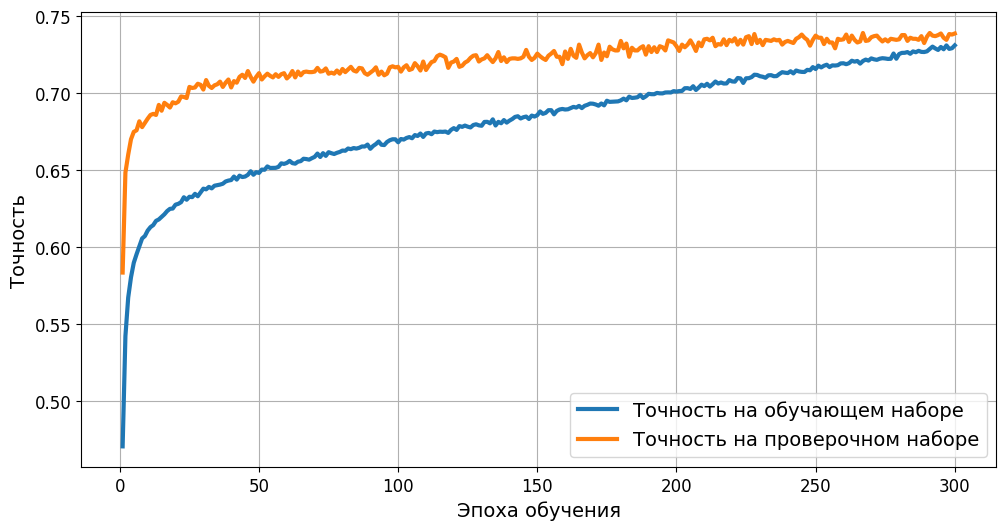

In [20]:
fit_chart(history)

**Сверточные слои А**

In [21]:
block_size = days_count*8

# создание модели
model = create_model_conv_a(train_x.shape[1], model_params, block_size)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
59/59 [==============================] - 13s 29ms/step - loss: 2.3081e-05 - accuracy: 0.3895 - val_loss: 1.0867 - val_accuracy: 0.4997
Epoch 2/300
59/59 [==============================] - 1s 9ms/step - loss: 2.0872e-05 - accuracy: 0.4851 - val_loss: 1.0622 - val_accuracy: 0.5460
Epoch 3/300
59/59 [==============================] - 1s 10ms/step - loss: 1.9508e-05 - accuracy: 0.5350 - val_loss: 1.0285 - val_accuracy: 0.5852
Epoch 4/300
59/59 [==============================] - 1s 9ms/step - loss: 1.8502e-05 - accuracy: 0.5658 - val_loss: 0.9872 - val_accuracy: 0.6041
Epoch 5/300
59/59 [==============================] - 1s 8ms/step - loss: 1.7801e-05 - accuracy: 0.5860 - val_loss: 0.9389 - val_accuracy: 0.6219
Epoch 6/300
59/59 [==============================] - 0s 8ms/step - loss: 1.7355e-05 - accuracy: 0.5967 - val_loss: 0.8867 - val_accuracy: 0.6429
Epoch 7/300
59/59 [==============================] - 1s 9ms/step - loss: 1.6885e-05 - accuracy: 0.6078 - val_loss: 0.8408 - val

In [22]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 80.8 %
Точность класса 1: 61.0 %
Точность класса 2: 71.6 %
[[1231  268   24]
 [ 290  645  123]
 [  15   79  237]]
Общая точность: 0.7256181318681318


In [23]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 91.8 %
Точность класса 1: 60.6 %
Точность класса 2: 65.0 %
[[2334  204    4]
 [ 117  212   21]
 [   1    6   13]]
Общая точность: 0.8787774725274725


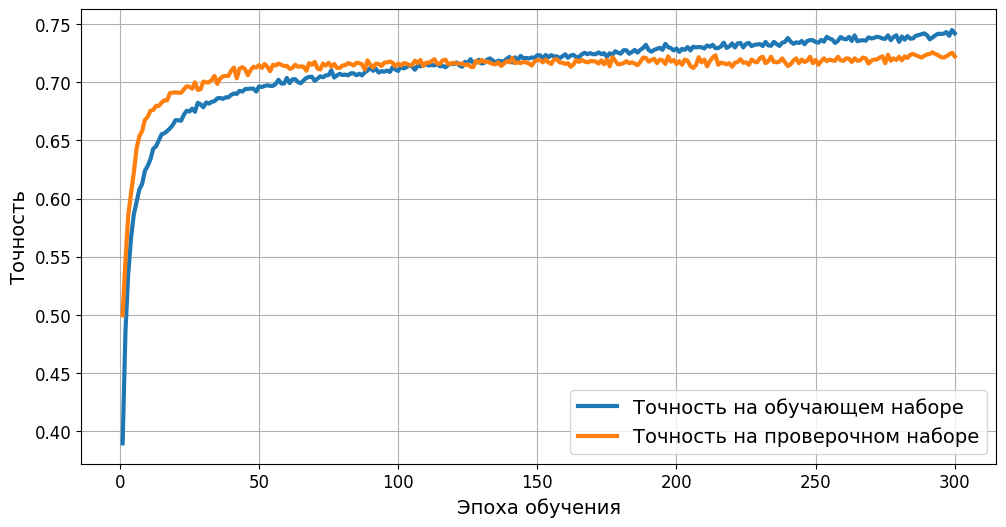

In [24]:
fit_chart(history)

**Сверточные слои B**

In [25]:
# создание модели
model = create_model_conv_b(train_x.shape[1], model_params)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
59/59 [==============================] - 3s 16ms/step - loss: 2.3632e-05 - accuracy: 0.3749 - val_loss: 1.0573 - val_accuracy: 0.5247
Epoch 2/300
59/59 [==============================] - 0s 8ms/step - loss: 2.0120e-05 - accuracy: 0.5071 - val_loss: 1.0263 - val_accuracy: 0.5807
Epoch 3/300
59/59 [==============================] - 1s 9ms/step - loss: 1.8781e-05 - accuracy: 0.5459 - val_loss: 0.9916 - val_accuracy: 0.6089
Epoch 4/300
59/59 [==============================] - 0s 8ms/step - loss: 1.8012e-05 - accuracy: 0.5733 - val_loss: 0.9464 - val_accuracy: 0.6247
Epoch 5/300
59/59 [==============================] - 1s 11ms/step - loss: 1.7436e-05 - accuracy: 0.5842 - val_loss: 0.8950 - val_accuracy: 0.6425
Epoch 6/300
59/59 [==============================] - 1s 12ms/step - loss: 1.7139e-05 - accuracy: 0.5973 - val_loss: 0.8441 - val_accuracy: 0.6552
Epoch 7/300
59/59 [==============================] - 1s 10ms/step - loss: 1.6794e-05 - accuracy: 0.6105 - val_loss: 0.8108 - va

In [26]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 3ms/step
Точность класса 0: 83.0 %
Точность класса 1: 61.1 %
Точность класса 2: 70.4 %
[[1264  248   11]
 [ 321  646   91]
 [  13   85  233]]
Общая точность: 0.7359203296703297


In [27]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 0s 2ms/step
Точность класса 0: 92.8 %
Точность класса 1: 60.0 %
Точность класса 2: 55.0 %
[[2358  183    1]
 [ 123  210   17]
 [   1    8   11]]
Общая точность: 0.8856456043956044


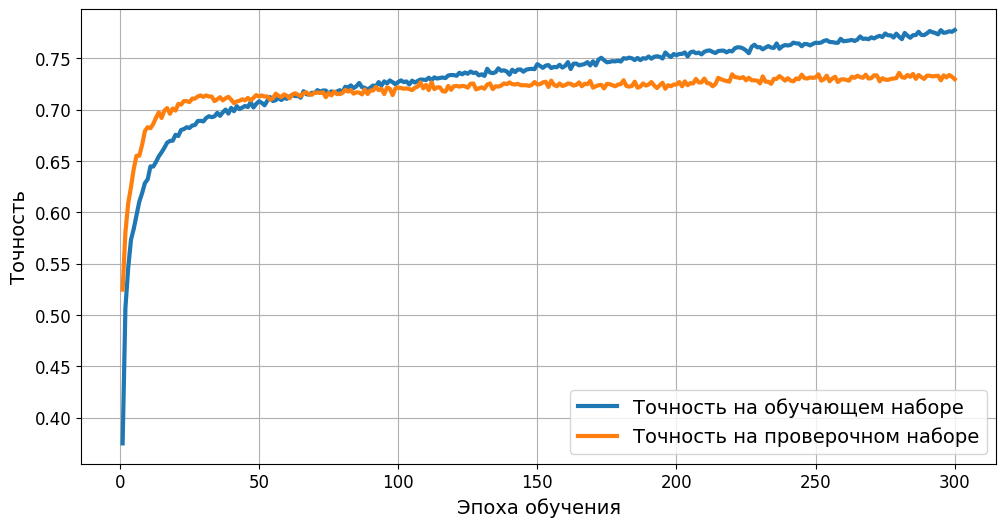

In [28]:
fit_chart(history)

**lstm**

In [29]:
block_size = days_count*8

# создание модели
model = create_model_lstm(train_x.shape[1], model_params, block_size)
# компиляция
compile_model(model, model_params)
# обучение
history = fitting_model(model, model_params,
                        train_x,
                        train_y,
                        val_x,
                        val_y)
# лучшая точность на проверке
print('\nЛучшая точность на проверочной выборке:', max(history.history['val_accuracy']))

Epoch 1/300
59/59 [==============================] - 14s 48ms/step - loss: 2.3442e-05 - accuracy: 0.4042 - val_loss: 1.0851 - val_accuracy: 0.4969
Epoch 2/300
59/59 [==============================] - 1s 14ms/step - loss: 2.1023e-05 - accuracy: 0.4625 - val_loss: 1.0788 - val_accuracy: 0.5117
Epoch 3/300
59/59 [==============================] - 1s 14ms/step - loss: 1.9939e-05 - accuracy: 0.5105 - val_loss: 1.0668 - val_accuracy: 0.5491
Epoch 4/300
59/59 [==============================] - 1s 14ms/step - loss: 1.9176e-05 - accuracy: 0.5370 - val_loss: 1.0475 - val_accuracy: 0.5707
Epoch 5/300
59/59 [==============================] - 1s 14ms/step - loss: 1.8578e-05 - accuracy: 0.5578 - val_loss: 1.0199 - val_accuracy: 0.5938
Epoch 6/300
59/59 [==============================] - 1s 14ms/step - loss: 1.8131e-05 - accuracy: 0.5695 - val_loss: 0.9903 - val_accuracy: 0.6034
Epoch 7/300
59/59 [==============================] - 1s 14ms/step - loss: 1.7736e-05 - accuracy: 0.5814 - val_loss: 0.9504 

In [30]:
# Проверочная выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, val_x, val_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 2s 6ms/step
Точность класса 0: 79.3 %
Точность класса 1: 61.2 %
Точность класса 2: 73.4 %
[[1208  290   25]
 [ 271  648  139]
 [   9   79  243]]
Общая точность: 0.7208104395604396


In [31]:
# Тестовая выборка
total_accuracy, accuracies, cm = get_accuracy_report(model, test_x, test_y)
for index, value in enumerate(accuracies):
  print(f"Точность класса {index}: {round(value*100, 2)} %")
print(cm)
print(f"Общая точность: {total_accuracy}")

91/91 [==============================] - 1s 6ms/step
Точность класса 0: 91.5 %
Точность класса 1: 62.3 %
Точность класса 2: 65.0 %
[[2326  214    2]
 [ 112  218   20]
 [   1    6   13]]
Общая точность: 0.8780906593406593


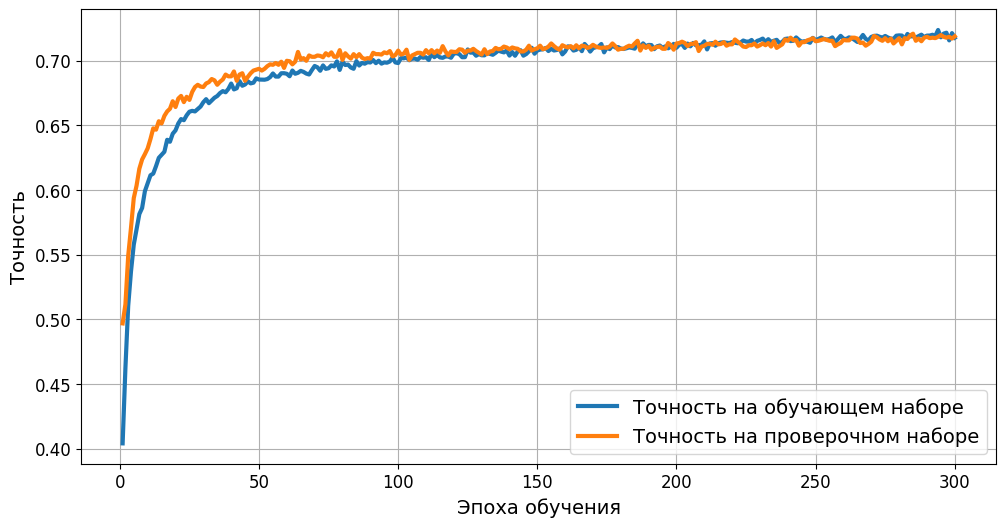

In [32]:
fit_chart(history)